In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pycocotools.coco import COCO
import requests
import os
import json
import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import skimage
import cv2
from skimage.transform import resize
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision
import torch.nn.functional as F
import torch
from torchvision import transforms as tvt
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class mycocoDataset(Dataset):
      def __init__(self, root, input_json, class_list, resize=None, transforms=None):
          self.root = root
          self.transforms = transforms
          self.input_json = input_json
          self.coco = COCO(self.input_json)
          self.calss_list=class_list
          self.resize=resize
          coco=self.coco
          catIds = coco.getCatIds(catNms = class_list)
          categories = coco.loadCats(catIds)
          imgIds = coco.getImgIds(catIds = catIds)
          self.catIds=catIds
          self.imgIds=imgIds
          coco_labels_to_classifying_labels = {}
          categories.sort (key = lambda x: x["id"])
          for idx , in_class in enumerate ( class_list ):
              for c in categories :
                  if c['name'] == in_class:
                     coco_labels_to_classifying_labels[c['id']] = idx
          self.coco_labels_to_classifying_labels=coco_labels_to_classifying_labels
      def __getitem__(self, index):
          coco = self.coco
          imgIds = self.imgIds
          img = coco.loadImgs(imgIds[index])[0]
          img_path=os.path.join(self.root, img ['file_name'])
          j=0
          if os.path.exists(img_path):
             II = Image.open(img_path)
             if II.mode != "RGB":
                II=II.convert(mode="RGB")
             j=1
             I = np.uint8 (II)
             annIds = coco.getAnnIds(imgIds = img['id'], catIds = self.catIds,iscrowd = False )
             anns = coco.loadAnns(annIds)
             boxes = []
             labels= []
             areas= []
             t_boxes=[]
             for ann in anns:
                 xmin = ann['bbox'][0]
                 ymin = ann['bbox'][1]
                 xmax = xmin + ann['bbox'][2]
                 ymax = ymin + ann['bbox'][3]
                 t_boxes.append([xmin, ymin, xmax, ymax])
                 areas.append(ann['area'])
                 if self.resize:
                    II=II.resize((self.resize[0],self.resize[1]),Image.BOX)
                    y_scale=int(I.shape[0]/self.resize[0])
                    x_scale=int(I.shape[1]/self.resize[1])
                    xmin = int(xmin/x_scale)
                    ymin = int(ymin/y_scale)
                    xmax = int(xmax/x_scale)
                    ymax = int(ymax/y_scale)
                 boxes.append([xmin, ymin, xmax, ymax])
                 labels.append(self.coco_labels_to_classifying_labels[ann["category_id"]])
             inn=areas.index(max(areas))    
             II = tvt.ToTensor()(II)
             boxes = torch.as_tensor(boxes[inn], dtype=torch.float32)
             labels= torch.as_tensor(labels[inn], dtype=torch.torch.int64)
             t_boxes = torch.as_tensor(t_boxes[inn], dtype=torch.torch.int64)
             my_target = {}
             my_target["true_bboxes"]=t_boxes
             my_target["image"] = II
             my_target["bboxes"] = boxes
             my_target["labels"] = labels
             my_target["names"] = img ['file_name']
             return my_target
      def __len__(self):
          return len(self.imgIds)
      

In [ ]:
root='/content/drive/MyDrive/Deep_learning/HW5/images_valid'
input_json="/content/drive/MyDrive/Deep_learning/HW5/annotations/instances_val2017.json"
class_list = ["car","boat"]
transform = tvt.Compose([tvt.ToTensor(),tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#transform=None
resize=[64,64]
test_dataset=mycocoDataset(root, input_json, class_list, resize=resize, transforms=transform)
test_data_loader = DataLoader(dataset = test_dataset,batch_size =50,shuffle =False,num_workers=2)

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


In [ ]:
####### This class is designed in a way that the input channels should be a multiple of output channels
#######, otherwise it would set the number of input channels equal to the output  channels.
#######  without downsampling this class only applys one convolutional layer
#######  with down sampling this class applys two convolutional layers

class mySkipBlock(torch.nn.Module):
      def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True):
          super(mySkipBlock, self).__init__()
          self.downsample = downsample 
          self.skip_connections = skip_connections
          self.in_ch = in_ch
          self.out_ch = out_ch
          if self.out_ch % self.in_ch !=0:
		         self.in_ch = self.out_ch
          self.convo1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
          norm_layer1 = nn.BatchNorm2d
          norm_layer2 = nn.BatchNorm2d
          self.bn1 = norm_layer1(out_ch)
          self.bn2 = norm_layer2(out_ch)
          if downsample:
             self.downsampler = nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1)
      def forward(self,x):
          identity=x.clone()
          out=self.convo1(x)
          out = self.bn1(out)
          out = F.relu(out)
          if self.downsample:
             out = self.downsampler(out)
             out = self.bn2(out)
             out=F.relu(out)
             identity = self.downsampler(identity)
          if self.skip_connections:
             initial=0
             segments=int(self.out_ch/self.in_ch)
             for i in range(segments):
                 out[:,initial:self.in_ch+initial,:,:] += identity
                 initial = self.in_ch+initial
          return out

In [ ]:
class myLOADnet(torch.nn.Module):
      def __init__(self, image_w=64, image_h=64, skip_connections=True, input_to_skip_blocks=64, output_of_skip_blocks=120, depth=9):
          super(myLOADnet, self).__init__()
          if (depth-1)%2 !=0 or depth <7 :
             sys.exit(" myLOADnet only accepts odd depths>=7")
          self.input_to_skip_blocks = input_to_skip_blocks
          self.output_of_skip_blocks = output_of_skip_blocks
          self.depth = depth 
          self.number_of_single_layers=(self.depth-2*2-1)//2
          self.conv = nn.Conv2d(3, input_to_skip_blocks, 3, padding=1)
          self.pool = nn.MaxPool2d(2, 2)
          self.image_w = image_w
          self.image_h = image_h
          self.image_w=int((self.image_w-2)/2+1)
          self.image_h=int((self.image_h-2)/2+1)
          self.image_w_af_pool=self.image_w
          self.image_h_af_pool=self.image_h
          self.skipinput_downsample = mySkipBlock(self.input_to_skip_blocks, self.input_to_skip_blocks,\
                                                  downsample=True, skip_connections=skip_connections) ##adds 2 layers
          self.image_w=int((self.image_w-3+2)/2+1)
          self.image_h=int((self.image_h-3+2)/2+1)
          self.skipinput_arr = nn.ModuleList()
          for i in range(self.number_of_single_layers):
              self.skipinput_arr.append(mySkipBlock(self.input_to_skip_blocks, self.input_to_skip_blocks, skip_connections=skip_connections)) ### adds (depth-2*2-1)//2  layers
          self.skipinput_to_ouput= mySkipBlock(self.input_to_skip_blocks, self.output_of_skip_blocks, skip_connections=skip_connections) ##adds 1 layer
          self.skipoutput_arr = nn.ModuleList()
          self.image_w=int((self.image_w-3+2)/2+1)
          self.image_h=int((self.image_h-3+2)/2+1)
          for i in range(self.number_of_single_layers):
              self.skipoutput_arr.append(mySkipBlock(self.output_of_skip_blocks, self.output_of_skip_blocks, skip_connections=skip_connections)) ### adds (depth-2*2-1)//2  layers 
          self.skipoutput_downsample = mySkipBlock(self.output_of_skip_blocks, self.output_of_skip_blocks, downsample=True, skip_connections=skip_connections) ##adds 2 layers
          self.fc1 = nn.Linear(self.image_w*self.image_h*self.output_of_skip_blocks, 1000)
          self.fc2 = nn.Linear(1000, 2)####2labels
     ########regression################
          self.conv_seqn = nn.Sequential(
          nn.Conv2d(in_channels=self.input_to_skip_blocks, out_channels=self.input_to_skip_blocks, kernel_size=3, padding=1),
          nn.BatchNorm2d(input_to_skip_blocks),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=self.input_to_skip_blocks, out_channels=self.output_of_skip_blocks, kernel_size=3, padding=1),
          nn.ReLU(inplace=True))
          self.fc_seqn = nn.Sequential(
          nn.Linear(self.image_w_af_pool*self.image_h_af_pool*self.output_of_skip_blocks, 1024),
          nn.ReLU(inplace=True),
          nn.Linear(1024, 512),
          nn.ReLU(inplace=True),
          nn.Linear(512, 4) )## output for the 4 coords (x_min,y_min,x_max,y_max) of BBox

      def forward(self,x):
          x = self.pool(F.relu(self.conv(x)))
          x1 = x.clone()
          x1=self.skipinput_downsample(x1)
          for i,skip_input in enumerate(self.skipinput_arr):
              x1 = skip_input(x1)
          x1=self.skipinput_to_ouput(x1)
          x1=self.skipoutput_downsample(x1)
          for i,skip_output in enumerate(self.skipoutput_arr):
              x1 = skip_output(x1)
          x1 = x1.view(-1, self.image_w*self.image_h*self.output_of_skip_blocks)
          x1 = F.relu(self.fc1(x1))
          x1 = self.fc2(x1)
          ## The Bounding Box regression:
          x2 = self.conv_seqn(x)
            # flatten
          x2 = x2.view(x.size(0), -1)
          x2 = self.fc_seqn(x2)
          return x1,x2

In [ ]:
input_file='/content/drive/MyDrive/Deep_learning/HW5/results_3/net.pth'
seed = 0
random.seed(seed)
torch.manual_seed(seed)
device = torch.device ("cuda:0" if torch.cuda.is_available () 
                                  else "cpu")
net = myLOADnet(image_w=resize[1], image_h=resize[1], skip_connections=True, input_to_skip_blocks=64, output_of_skip_blocks=128, depth=9)
net = net.to(device)
net.load_state_dict(torch.load(input_file, map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
for i, data in enumerate(test_data_loader):
        inputs, bbox_gt, labels = data["image"], data["bboxes"], data["labels"]
        image_names=[data["names"]]
        tt_boxes=[data["true_bboxes"]]
        inputs = inputs.to(device)
        bbox_gt = bbox_gt.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        label_pred = outputs[0] 
        bbox_pred = outputs[1]
predictions_labels = []
predictions_boxes = []
for j in range(label_pred.shape[0]):
	  predictions_labels.append(torch.argmax(label_pred[j]).cpu().numpy())
labels = np.array(labels.cpu())
bbox_pred = np.array(bbox_pred.cpu().detach().numpy())
bbox_gt = np.array(bbox_gt.cpu().detach().numpy())
tt_boxes = np.array(tt_boxes[0])


In [ ]:
print('truelabels=',labels)
print('predictedlabels=',predictions_labels)

truelabels= [0 1 1 1 1 1 0 1 1 1 1 0 1 1 1]
predictedlabels= [array(0), array(0), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1)]


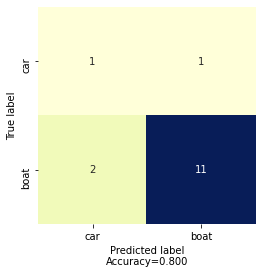

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
os.chdir('/content/drive/MyDrive/Deep_learning/HW5/results_3/')
cm_2=confusion_matrix(labels, predictions_labels)
plt.figure()
data_2 = pd.DataFrame(cm_2, class_list, class_list)
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", fmt = 'd', cbar = False)
score_2= accuracy_score(labels, predictions_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score_2))
plt.savefig('confusion_matrix.jpg', bbox_inches = 'tight', pad_inches = 0.2,dpi=500)

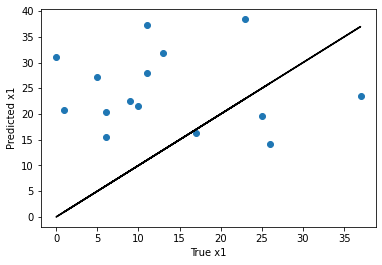

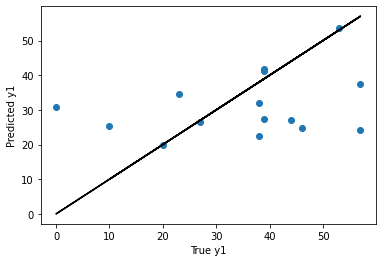

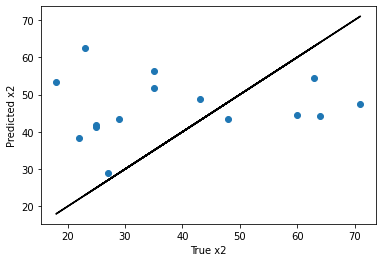

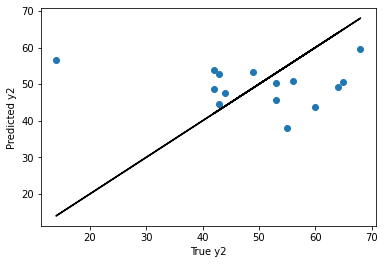

In [ ]:
os.chdir('/content/drive/MyDrive/Deep_learning/HW5/results_3')
plt.figure()
x1_s_pred=bbox_pred[:,0]
x1_s=bbox_gt[:,0]
plt.plot(x1_s,x1_s_pred,'o')
plt.plot(x1_s,x1_s,'k')
plt.xlabel('True x1')
plt.ylabel('Predicted x1')
plt.savefig('x1s.jpg', bbox_inches = 'tight', pad_inches = 0.2,dpi=500)
plt.figure()
y1_s_pred=bbox_pred[:,1]
y1_s=bbox_gt[:,1]
plt.plot(y1_s,y1_s_pred,'o')
plt.plot(y1_s,y1_s,'k')
plt.xlabel('True y1')
plt.ylabel('Predicted y1')
plt.savefig('y1s.jpg', bbox_inches = 'tight', pad_inches = 0.2,dpi=500)
plt.figure()
x2_s_pred=bbox_pred[:,2]
x2_s=bbox_gt[:,2]
plt.plot(x2_s,x2_s_pred,'o')
plt.plot(x2_s,x2_s,'k')
plt.xlabel('True x2')
plt.ylabel('Predicted x2')
plt.savefig('x2s.jpg', bbox_inches = 'tight', pad_inches = 0.2,dpi=500)
plt.figure()
y2_s_pred=bbox_pred[:,3]
y2_s=bbox_gt[:,3]
plt.plot(y2_s,y2_s_pred,'o')
plt.plot(y2_s,y2_s,'k')
plt.xlabel('True y2')
plt.ylabel('Predicted y2')
plt.savefig('y2s.jpg', bbox_inches = 'tight', pad_inches = 0.2,dpi=500)